# Introduction
This notebook loads in analysis of B-cells isolated from PBMC's from a healthy donor and analyzed on the 10X Genomics platform. Data was downloaded from the 10X website (https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/fresh_68k_pbmc_donor_a). Instructions on using the ``matrix.mtx`` files are included here: https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices. We will follow this tutorial

In [1]:
# import necessary packages
import csv
import os
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import scipy.sparse as sps
import multiprocessing as mp
import h5py
import cooler
import re
import seaborn
import scipy.spatial.distance as ds

In [2]:
# set paths
genome = "hg19"
celltype = "bcells"
matfolder = "filtered_matrices_mex"
clusterfolder = "analysis_csv"
scrnaseq_dir = "../scrnaseq_10x/"

bcell_matrix_dir = os.path.join(scrnaseq_dir,celltype,matfolder,genome)
bcell_analysis_dir = os.path.join(scrnaseq_dir,celltype,clusterfolder)

pca_dir = os.path.join(bcell_analysis_dir,"pca")
tsne_dir = os.path.join(bcell_analysis_dir,"tsne")
kmeans_dir = os.path.join(bcell_analysis_dir,"kmeans")

In [4]:
#set import functions

def import_matrix_mtx_file(filename,aspd=False):
    inmat = scipy.io.mmread(source=filename)
    if (aspd==True):
        return(pd.SparseDataFrame(inmat))
    else:
        return(inmat)

#how can we generate a SparseDataFrame from a Sparse Matrix without creating a dense matrix in memory?

# def import_csv(filename,delimiter="\t"):
#     ids = [row[0] for row in csv.reader(open(filename), delimiter=delimiter)]
#     names = [row[1] for row in csv.reader(open(filename), delimiter=delimiter)]
#     return(ids,names)


In [5]:
#import the file. Use multiprocessing to make this run smoother

inmatrix = os.path.join(bcell_matrix_dir, "matrix.mtx")
genes_path = os.path.join(bcell_matrix_dir, "genes.tsv")
barcodes_path = os.path.join(bcell_matrix_dir, "barcodes.tsv")


In [6]:
#impor the matrix file
mp_pool = mp.Pool(5)
infile = mp_pool.map(import_matrix_mtx_file, [inmatrix])
mp_pool.close()

In [7]:
mat = infile[0]
print(mat.shape)
print(type(mat))
print(mat)
#rows are genes, columns are cells!

(32738, 10085)
<class 'scipy.sparse.coo.coo_matrix'>
  (32732, 0)	1.0
  (32708, 0)	2.0
  (32705, 0)	3.0
  (32702, 0)	12.0
  (32699, 0)	2.0
  (32698, 0)	17.0
  (32697, 0)	2.0
  (32696, 0)	9.0
  (32645, 0)	2.0
  (32643, 0)	1.0
  (32641, 0)	1.0
  (32595, 0)	1.0
  (32502, 0)	1.0
  (32437, 0)	1.0
  (32416, 0)	1.0
  (32398, 0)	1.0
  (32187, 0)	1.0
  (32186, 0)	1.0
  (32132, 0)	1.0
  (32120, 0)	1.0
  (32105, 0)	1.0
  (32099, 0)	1.0
  (32067, 0)	1.0
  (32047, 0)	1.0
  (32045, 0)	1.0
  :	:
  (610, 10084)	1.0
  (607, 10084)	1.0
  (601, 10084)	1.0
  (594, 10084)	1.0
  (558, 10084)	10.0
  (556, 10084)	1.0
  (528, 10084)	2.0
  (525, 10084)	1.0
  (500, 10084)	1.0
  (492, 10084)	40.0
  (490, 10084)	2.0
  (484, 10084)	1.0
  (482, 10084)	1.0
  (457, 10084)	1.0
  (446, 10084)	1.0
  (412, 10084)	2.0
  (363, 10084)	1.0
  (316, 10084)	1.0
  (248, 10084)	1.0
  (201, 10084)	1.0
  (166, 10084)	3.0
  (120, 10084)	1.0
  (105, 10084)	1.0
  (67, 10084)	2.0
  (42, 10084)	1.0


```
#attempts at h5py

#attempt to save as an h5py file

#mat.to_hdf(os.path.join(bcell_matrix_dir, "matrix.h5"), 'sparse_df')

# with h5py.File(os.path.join(bcell_matrix_dir, "matrix.h5"), 'w') as hf:
#     hf.create_dataset("bcell_8k",  data=mat)

#filepath = os.path.join(bcell_matrix_dir, "matrix.h5")
# filepath = os.path.join(bcell_matrix_dir, "matrix.h5")
# print(filepath)
# store1 = pd.HDFStore(os.path.join(bcell_matrix_dir, "matrix.h5"))


# import h5py
# h5 = h5py.File(filepath="../scrnaseq_10x/bcells/", 'r')

# import cooler
# cooler.matrix()


# #attempt to load
# with h5py.File(os.path.join(bcell_matrix_dir, "matrix.h5"), 'r') as hf:
#     indata = hf['bcell_8k'][:]
```

# Tiling the transcriptome

Since we have over 32,000 genes, we would like to condense them into genomic tiles that would allow us to work with a smaller, sparser matrix. 

1. We will import the GTF, intersect it with 100-kb genomic tiles (giving us roughly 10,000 regions), and convert the matrix from a ~32,000 x 10,000 matrix to a ~10,000 x 10,000 matrix. 
2. The reads for genes in each bin for each cell will be summed up so that the "transcriptional output" of the bin can be compared with other bins. 
3. We will then calculate the correlation matrix for the cell-bin matrix such that we correlate the transcriptional outputs of bin 1 with bin 2. We then save this as a "contact map" of sorts and output it to a file
4. We then convert the matrix into a Cooler file (using the 100-kb bins from earlier) and work it up in Ccooler or Hi-Glass

In [8]:
# load the gene IDs and names
gene_ids = [row[0] for row in csv.reader(open(genes_path), delimiter="\t")]
gene_names = [row[1] for row in csv.reader(open(genes_path), delimiter="\t")]

In [9]:
# load the barcode IDs
barcodes = [row[0] for row in csv.reader(open(barcodes_path), delimiter="\t")]

In [10]:
genes_df = pd.DataFrame()
genes_df = genes_df.assign(genename=pd.Series(gene_names),geneid=pd.Series(gene_ids))

for multi-core jobs
https://stackoverflow.com/questions/33480675/multiprocessing-on-a-set-number-of-cores

## Import ENSEMBL GTF

In [11]:
#set ensembl file
#scrnaseq_dir = "../scrnaseq_10x/"
hg19gtf = "../hg19ref/refdata-cellranger-hg19-1.2.0/genes/genes.gtf"
hg19gtf_dir = os.path.join(scrnaseq_dir,hg19gtf)

hg19gtf_genes = pd.read_csv(hg19gtf,delimiter="\t",comment="#",header=None)

/Users/vinayakvsv/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
hg19gtf_genes.columns = ["chr","database","type","start","end","other","strand","other2","metadata"]

In [13]:
metadata = hg19gtf_genes.metadata.apply(lambda x: re.split(r"[a-zA-Z]+_[a-zA-Z]+ \"|\";",x)[1])

In [14]:
hg19gtf_genes['gene_id'] = pd.Series(metadata)
#hg19gtf_genes
hg19gtf_genes_expression = hg19gtf_genes[hg19gtf_genes.gene_id.isin(gene_ids) & hg19gtf_genes.type.isin(["gene"])]
print(hg19gtf_genes_expression.shape)

(32738, 10)


In [ ]:
#how do we efficiently identify blocks? Bin the genome into 100 kb blocks and calculate correlations between genes within them?

#first, let's get a distribution of correlation values:
#n, bins, patches = plt.hist(test_corr_nona[0:100][0:100])
#plt.show()


# Visualization
Let's view the cell clusters

We now load T-SNE metadata for this population. We will show what the populations look like and then isolate the cells responsible to generate co-expression blocks

In [15]:
#tsne_data = scipy.io.mmread(os.path.join(tsne_dir, "projection.csv")) 
tsne_data = os.path.join(tsne_dir, "projection.csv")
tsne_points = [row for row in csv.reader(open(tsne_data), delimiter=",")]
tsne_meta = pd.DataFrame(tsne_points[1:])
tsne_meta.columns = tsne_points[0]

In [16]:
#import clustering
cluster_10 = os.path.join(kmeans_dir,"10_clusters")
print(cluster_10)
#get the cluster designations
cluster_10_ids = pd.read_csv(os.path.join(cluster_10,"clusters.csv"))
#cluster_10_ids
#kmeans_10 = os.path.join(pca_dir,"10_clusters") 

../scrnaseq_10x/bcells/analysis_csv/kmeans/10_clusters


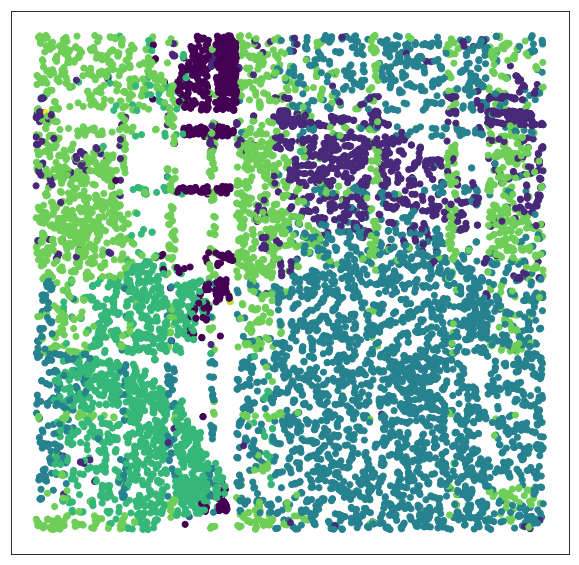

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_meta.iloc[:,1],tsne_meta.iloc[:,2],c = cluster_10_ids.iloc[:,1])
plt.xticks([])
plt.yticks([])
plt.show()

# Isolate groups of cells
Now, we want to identify putative groups of cells (from the 10-cluster scheme) and calculate co-expression matrices fo the genes using measurements from each cluster of cells (we will have as any matrices as we have cells). We will calculate these co-expression matrices for the whole set of ~30,000 genes and represent it as a plot. 

In [ ]:
# cellgroups = [None for i in clusters]
# for i in clusters:
#     cells = cluster_10_ids[cluster_10_ids.Cluster == i] #get the cells in the cluster "i"
#     cells_ind = cells.index
#     mat_csr = mat.tocsr()
#     cellgroups[i-1] = scipy.sparse.coo_matrix(mat_csr[:,cells_ind.tolist()]) #cells_ind  

In [19]:
# def get_cluster(clusterid,cellmat,cluster_ids):
#     cells = cluster_ids[cluster_ids.Cluster == clusterid]
#     cells_ind = cells.index
#     mat_csr = mat.tocsr()
#     return(scipy.sparse.coo_matrix(mat_csr[:,cells_ind.tolist()]))

def get_cluster(clusterid,celldf,cluster_ids):
    cells = cluster_ids[cluster_ids.Cluster == clusterid]
    cells_ind = cells.index
#     mat_cells_ind = celldf.iloc[:,cells_ind.tolist()]  
    return(celldf.tocsr()[:,cells_ind].tocoo())
#     return(mat_cells_ind)
#    mat_csr = mat.tocsr()
#    return(scipy.sparse.coo_matrix(mat_csr[:,cells_ind.tolist()]))

In [20]:
mp_pool = mp.Pool(4)
clusters = [(i,mat,cluster_10_ids) for i in set(cluster_10_ids.iloc[:,1])]
cellgroups = mp_pool.starmap(get_cluster, clusters)
mp_pool.close()

In [21]:
mat1 = cellgroups[0]
print(type(mat1))

<class 'scipy.sparse.coo.coo_matrix'>


## Calcuate co-ex

In [22]:
def calculate_sparsemat_correlation(sparsemat):
    #A = sparsemat + 1e-120 #add an infinitesmal pseudocount #I should probably add random "noise" to preserve the correlations
    A = sparsemat # + We want to input some random noise so that the preponderance of zeroes does not turn up nan-level correlations 
    n = A.shape[1] #gets the number of cells; shape[0[] would give the number of variables
    rowsum = A.sum(1)
    
    #compute covariance matrix
    centering = rowsum.dot(rowsum.T.conjugate()) / n
    C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

    # The correlation coefficients are given by
    # C_{i,j} / sqrt(C_{i} * C_{j})
    d = np.diag(C)
    coeffs = C / np.sqrt(np.outer(d, d))

    return C#coeffs


In [ ]:
# from scipy.sparse import random
# from scipy import stats
# class CustomRandomState(object):
#     def randint(self, k):
#         i = np.random.randint(k)
#         return i - i % 2
# rs = CustomRandomState()
# rvs = stats.poisson(2, loc=1).rvs
# S = random(1000, 10000, density=0.25, random_state=rs, data_rvs=rvs)
# print(S.A)
# print(np.corrcoef(S.A))

In [ ]:
# def calculate_corr(pd_df):
#     return pd_df.T.corr(method="pearson") #pearson is default

In [23]:
for i in cellgroups:
    print(i.shape)

(32738, 664)
(32738, 1275)
(32738, 1)
(32738, 1)
(32738, 3882)
(32738, 1)
(32738, 1636)
(32738, 2623)
(32738, 1)
(32738, 1)


In [24]:
#keey the clusters that have more than 'ncell' cells
ncell = 1
inds = [None for i in range(len(cellgroups))]
for i in range(len(cellgroups)):
    if cellgroups[i].shape[1] > ncell:
        inds[i] = i
inds = [i for i in inds if i is not None]
print(inds)
#corrdfs_actual = [corrdfs[i] for i in inds]
cellgroups_keep = [cellgroups[i] for i in inds]
for i in [j for j in cellgroups_keep]:
    print(i.shape)

[0, 1, 4, 6, 7]
(32738, 664)
(32738, 1275)
(32738, 3882)
(32738, 1636)
(32738, 2623)


In [ ]:
# https://stackoverflow.com/questions/44553858/compute-a-pairwise-distance-matrix-is-a-scalable-big-data-ready-approach-avail
# https://stackoverflow.com/questions/19231268/correlation-coefficients-for-sparse-matrix-in-python
# https://stackoverflow.com/questions/34872854/how-to-ignore-zeros-when-calculating-correlations-between-columns-for-sparse-mat

In [25]:
mat1 = cellgroups_keep[0]
print(mat1.shape)

(32738, 664)


# Isolating co-expression domains

Rather than solving a "clustering" problem, we would like to identify contiguous blocks along the diagonal where "squares" exist. This is essentially a Hi-C problem (to call TADs), and we can involve "cooltools" to do so.

We could think of the problem "algorithmically" as such: Given n points and n^2 relationships to each other, how can we identify m groupings such that the total signal within the...


The counts are rather sparse for a given set of cells. Most of the genes have 0 counts across all of the cells. See below

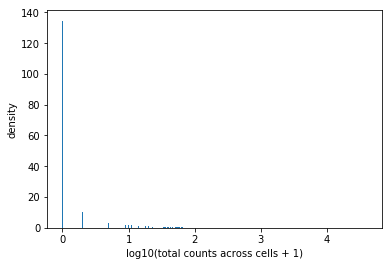

In [26]:
plt.hist(np.log10(np.sum(mat1,axis=1)+1),bins=1000,density=True)
plt.xlabel(s="log10(total counts across cells + 1)")
plt.ylabel(s="density")
plt.show()

## Remove zero-sum genes

First, we will remove genes from the matrix that have zero-sum across all of the cells (since such genes have an "indeterminate" status across the cells

In [27]:
mat1_sumxcells = np.sum(mat1,axis=1)
zerogenes_ind = np.where(mat1_sumxcells != mat1_sumxcells.min())[0].tolist()

mask = genes_df.index.isin(zerogenes_ind)
nonzero_genes = genes_df[~mask]

In [29]:
nonzero_genes.shape

(20271, 2)

Now, we compute the pairwise correlation of genes

In [36]:
def filter_genes(imat,ingenes):
    #first, remove genes that have zero sums all throughout the cells
    mat1_sumxcells = np.sum(mat1,axis=1)
    zerogenes_ind = np.where(mat1_sumxcells != mat1_sumxcells.min())[0].tolist()

    mask = ingenes.index.isin(zerogenes_ind)
    nonzero_genes = genes_df[~mask]

    return(nonzero_genes)

def calculate_correlation_matrices(inmat,ingenes):
    #first, remove genes that have zero sums all throughout the cells
    mat1_sumxcells = np.sum(mat1,axis=1)
    zerogenes_ind = np.where(mat1_sumxcells != mat1_sumxcells.min())[0].tolist()

    mask = ingenes.index.isin(zerogenes_ind)
    nonzero_genes = genes_df[~mask]
    
    mat1_nonzerogenes = mat1.todense()[zerogenes_ind,:]
    mat1_nonzerogenes_sparse = sps.coo_matrix(np.corrcoef(mat1_nonzerogenes))
    
    return(mat1_nonzerogenes_sparse)

In [ ]:
# #print(type(mat1_sumxcells))
# mat1_nonzerogenes = mat1.todense()[zerogenes_ind,:]
# mat1_nonzerogenes_sparse = sps.coo_matrix(np.corrcoef(mat1_nonzerogenes))

In [57]:
mp_pool.close()

In [43]:
mp_pool = mp.Pool(4)
inputmats = [(i,genes_df) for i in cellgroups_keep]
#print(inputmats)
filtgenes = mp_pool.starmap(filter_genes,inputmats)
#cormats = mp_pool.starmap(calculate_correlation_matrices,inputmats)
mp_pool.close()

In [52]:
for i in cellgroups_keep:
    print(i)

  (5, 120)	1.0
  (5, 161)	1.0
  (5, 413)	1.0
  (23, 261)	1.0
  (23, 326)	2.0
  (26, 145)	1.0
  (26, 186)	1.0
  (26, 247)	1.0
  (26, 291)	1.0
  (26, 575)	1.0
  (27, 230)	1.0
  (27, 358)	1.0
  (27, 452)	1.0
  (35, 11)	1.0
  (35, 15)	2.0
  (35, 17)	2.0
  (35, 35)	1.0
  (35, 38)	1.0
  (35, 42)	2.0
  (35, 54)	1.0
  (35, 56)	1.0
  (35, 60)	1.0
  (35, 61)	1.0
  (35, 69)	1.0
  (35, 79)	1.0
  :	:
  (32732, 169)	1.0
  (32732, 228)	1.0
  (32732, 229)	1.0
  (32732, 235)	1.0
  (32732, 240)	1.0
  (32732, 243)	1.0
  (32732, 256)	1.0
  (32732, 259)	1.0
  (32732, 288)	1.0
  (32732, 291)	1.0
  (32732, 324)	1.0
  (32732, 393)	1.0
  (32732, 409)	1.0
  (32732, 417)	1.0
  (32732, 420)	1.0
  (32732, 435)	1.0
  (32732, 447)	1.0
  (32732, 521)	1.0
  (32732, 531)	1.0
  (32732, 541)	1.0
  (32732, 548)	1.0
  (32732, 583)	1.0
  (32732, 599)	1.0
  (32732, 626)	1.0
  (32732, 631)	2.0
  (5, 822)	1.0
  (5, 826)	1.0
  (26, 28)	1.0
  (26, 100)	1.0
  (26, 313)	1.0
  (26, 337)	1.0
  (26, 401)	1.0
  (26, 470)	1.0
  (26, 56

In [45]:
#mp_pool = mp.Pool(4)
#cormats = mp_pool.starmap_async(calculate_correlation_matrices,inputmats)
mp_pool.close()

In [47]:
cormats = []
for i in inputmats:
    cormats.append(calculate_correlation_matrices(i[0],i[1]))

In [53]:
for i in cormats:
    print(i.shape)

(12467, 12467)
(12467, 12467)
(12467, 12467)
(12467, 12467)
(12467, 12467)


In [51]:
cormats[0].todense()

matrix([[ 1.        , -0.00351238, -0.00586816, ..., -0.00261639,
         -0.0127613 , -0.01442843],
        [-0.00351238,  1.        , -0.00454134, ..., -0.00202481,
         -0.0098759 , -0.01116609],
        [-0.00586816, -0.00454134,  1.        , ..., -0.00338287,
         -0.01649974,  0.06126151],
        ..., 
        [-0.00261639, -0.00202481, -0.00338287, ...,  1.        ,
         -0.00735662, -0.00831769],
        [-0.0127613 , -0.0098759 , -0.01649974, ..., -0.00735662,
          1.        , -0.04056899],
        [-0.01442843, -0.01116609,  0.06126151, ..., -0.00831769,
         -0.04056899,  1.        ]])

In [50]:
cormats[1].todense()

matrix([[ 1.        , -0.00351238, -0.00586816, ..., -0.00261639,
         -0.0127613 , -0.01442843],
        [-0.00351238,  1.        , -0.00454134, ..., -0.00202481,
         -0.0098759 , -0.01116609],
        [-0.00586816, -0.00454134,  1.        , ..., -0.00338287,
         -0.01649974,  0.06126151],
        ..., 
        [-0.00261639, -0.00202481, -0.00338287, ...,  1.        ,
         -0.00735662, -0.00831769],
        [-0.0127613 , -0.0098759 , -0.01649974, ..., -0.00735662,
          1.        , -0.04056899],
        [-0.01442843, -0.01116609,  0.06126151, ..., -0.00831769,
         -0.04056899,  1.        ]])

We can also perform a distance calculation

In [ ]:
d = ds.pdist(mat1_nonzerogenes_sparse.todense(), 'correlation')

In [ ]:
print(d)

In [ ]:
print(mat1_nonzerogenes_sparse.todense())

In [54]:
# for i in cormats:
# #     seaborn.heatmap(mat1_nonzerogenes_sparse.todense()[0:1000,0:1000])
#     seaborn.heatmap(i.todense())
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
# #plt.plot(mat1_nonzerogenes_sparse.todense()[0:100][0:100])
# #plt.show()

KeyboardInterrupt: 

## Correlation for all cells

In [59]:
# inputmats = [(mat,genes_df)] # for i in cellgroups_keep]


# mp_pool = mp.Pool(4)
# filtgenes = mp_pool.starmap(filter_genes,inputmats)
# cormats = mp_pool.starmap(calculate_correlation_matrices,inputmats)
# mp_pool.close()

filtgenes = filter_genes(imat=mat,ingenes=genes_df)
cormat = calculate_correlation_matrices(ingenes=genes_df,inmat=mat)

# mat

In [61]:
cormat.shape

(12467, 12467)

In [75]:
cormat.todense()

matrix([[ 1.        , -0.00351238, -0.00586816, ..., -0.00261639,
         -0.0127613 , -0.01442843],
        [-0.00351238,  1.        , -0.00454134, ..., -0.00202481,
         -0.0098759 , -0.01116609],
        [-0.00586816, -0.00454134,  1.        , ..., -0.00338287,
         -0.01649974,  0.06126151],
        ..., 
        [-0.00261639, -0.00202481, -0.00338287, ...,  1.        ,
         -0.00735662, -0.00831769],
        [-0.0127613 , -0.0098759 , -0.01649974, ..., -0.00735662,
          1.        , -0.04056899],
        [-0.01442843, -0.01116609,  0.06126151, ..., -0.00831769,
         -0.04056899,  1.        ]])

We'll use this matrix

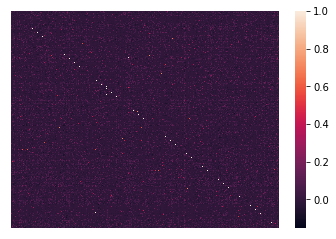

In [79]:
seaborn.heatmap(cormat.todense()[0:2000,0:2000])
plt.xticks([])
plt.yticks([])
plt.show()

## Map entries onto genomic intervals

## Export matrix

We want to export the correlation matrix so that we can convert it into a cooler file (and view the results in HiGlass)

## Other approaches

### Clustering

The clustering analysis turned out differentially-expressed genes for each cluster, so we could calculate a co-expression matrix using just those genes (rather than those with no counts recorded). Nevertheless, now we can perform matrix operations on the coo_matrix to identify the "blocks" of co-expressed genes.

This could be a job for "block modelling." https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix. However, we want to retain the positional ordering of genes in the matrix

### Binning genes

What we will do is import an ENSEMBL GTF of genes for hg19 and create "blocks" from which we can coarse-grain the gene co-expression matrix (and recalculate correlation between all genes being expressed by getting correlation of reads for each block). We can then perform "cooler" operations on the matrix to isolate co-expression blocks

### Outdated: correlations with the full set (TOO LONG!)

In [ ]:
# convert in a numpy array
m = np.array(mat1.todense())

# create the distance matrix using pdist
m1 = m + 1e-119 #add an infinitesmal to pseudocount 

sparsecorr = calculate_sparsemat_correlation(m1)

In [ ]:
scipy.sparse.random()

In [ ]:
d = ds.pdist(m[1:100,1:100], 'correlation')

d= ds.squareform(d)
print(np.amax(np.sum(np.corrcoef(m1[1:100,1:100]),axis=1)))

In [ ]:
mp_pool = mp.Pool(4)

#cellgroups_keep_T = [i.transpose() for i in cellgroups_keep]
# corrdfs = mp_pool.map(calculate_corr,cellgroups_keep)
corrdfs = mp_pool.map(calculate_sparsemat_covariance,cellgroups_keep)


print(corrdfs[0])
#print(cluster_0)
#print(cluster_0.shape)
#cluster_0.corr()
#cov_cluster_0 = calculate_sparsemat_correlation(cluster_0)
#cluster_0.sum(1).dot(cluster_0.sum(1).T.conjugate()).shape

In [ ]:
# Now, for associate each position on the correlation matrix with a gene from the 

In [ ]:
#corrdfs_actual[3]

In [ ]:
def plot_coo_matrix(m):
#     if not isinstance(m, scipy.sparse.coo_matrix):
#         m = scipy.sparse.coo_matrix(m)
    ax = plt.figure()
#    ax = fig.add_subplot(111, axisbg='black')
#    ax.plot(m.col, m.row, 's', ms=1)
#    ax.set_xlim(0, m.shape[1])
#    ax.set_ylim(0, m.shape[0])
#    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.stet_xticks([])
    ax.set_yticks([])
    return ax


In [ ]:
a = plot_coo_matrix(corrdfs[0])
a.figure

In [ ]:
# #from https://stackoverflow.com/questions/19231268/correlation-coefficients-for-sparse-matrix-in-python
# def sparse_corrcoef(A, B=None):

#     if B is not None:
#         A = sparse.vstack((A, B), format='csr')

#     A = A.astype(np.float64)
#     n = A.shape[1]
#     print(n)

#     # Compute the covariance matrix
#     rowsum = A.sum(1)
#     centering = rowsum.dot(rowsum.T.conjugate()) / n
#     C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

#     # The correlation coefficients are given by
#     # C_{i,j} / sqrt(C_{i} * C_{j})
#     d = np.diag(C)
#     coeffs = C / np.sqrt(np.outer(d, d))

#     return coeffs

In [ ]:
# for i in cellgroups:
#     print(i.shape)
# #cellgroups[4]
# #mat_csr = mat.tocsr()
# #mat_csr[2,cellgroups[0].tolist()]
# #    mat_group = mat.tocsc[0:100] cells_ind

In [ ]:
# test_corr = sparse_corrcoef(A=cellgroups[0])

In [ ]:
#import statsmodels

In [ ]:
test_corr_nona = np.nan_to_num(test_corr) #replace all NA with 0

In [ ]:
test_corr_sparse = scipy.sparse.coo_matrix(test_corr)
#print(type(test_corr_sparse))

#ax = sparse_corrcoef(test_corr)
#ax.figure

In [ ]:
print(np.amax(np.sum(a=test_corr_nona,axis=0))) #so this does work
test_corr_nona_sparse = scipy.sparse.coo_matrix(test_corr_nona) #store as a sparce matrix

In [ ]:
#import cooler
test_corr_nona_sparse.todense()

# Compare co-expression domains and contact scores from HiC data

We will perform the following procedure
1. For the lower-left diagonal of the matrix, take each diagonal slice parallel to the hypotenuse
    * Each slice represents some scale of genomic distance between regions. We would like to compute the whether particular contact-coexpression trends stand out over long genomic distances
2. Obtain both the contact scores and the expression correlation of all genes in the genomic bins throughout the slice. 
3. We ultimately want to calculate some "threshold" at which genomic proximity and gene co-expression are potentially significant. 
* Weight the signal used to compute correlation by the number of genes present (assign an "uncertainty" to the reads mapping to the genes in the bin)